In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **PHẦN 1: XỬ LÝ DỮ LIỆU**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DATA SET/Credit loans/german_credit_data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [ ]:
df.head(6)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
5,5,35,male,1,free,NaN,NaN,9055,36,education,good


In [ ]:
print("Unique values in 'Saving accounts':", df["Saving accounts"].unique())
print("Unique values in 'Checking account':", df["Checking account"].unique())


Unique values in 'Saving accounts': [nan 'little' 'quite rich' 'rich' 'moderate']
Unique values in 'Checking account': ['little' 'moderate' nan 'rich']


In [ ]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
df.isna().sum()

,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,183
Checking account,394
Credit amount,0
Duration,0
Purpose,0
Risk,0


In [ ]:
from sklearn.impute import SimpleImputer

# # Sử dụng SimpleImputer với strategy 'most_frequent' cho các cột phân loại
# imputer_cat = SimpleImputer(strategy='most_frequent')
# df[['Saving accounts', 'Checking account']] = imputer_cat.fit_transform(df[['Saving accounts', 'Checking account']])



In [ ]:
imputer_cat_constant = SimpleImputer(strategy='constant', fill_value='unknown')
df[['Saving accounts', 'Checking account']] = imputer_cat_constant.fit_transform(df[['Saving accounts', 'Checking account']])


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


# Mã hóa biến phân loại
label_encoders = {}
categorical_columns = ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose", "Risk"]

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Lưu bộ mã hóa nếu cần giải mã sau

# Tách biến đầu vào và đầu ra
X = df.drop(columns=["Risk"])  # Biến đầu vào
y = df["Risk"]  # Biến đầu ra


# **PHẦN 2: CHIA DỮ LIỆU VÀ CHUẨN HÓA**


In [ ]:
# Chia tập dữ liệu thành tập huấn luyện (80%) và tập kiểm tra (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# **PHẦN 3: HUẤN LUYỆN MÔ HÌNH**


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "SVM": SVC(probability=True, random_state=42),
}

trained_models = {}
for name, model in models.items():
    print(f"🔹 Đang huấn luyện: {name}")
    model.fit(X_train_scaled if name in ["Logistic Regression", "SVM"] else X_train, y_train)
    trained_models[name] = model


🔹 Đang huấn luyện: Logistic Regression
🔹 Đang huấn luyện: Decision Tree
🔹 Đang huấn luyện: Random Forest
🔹 Đang huấn luyện: XGBoost
🔹 Đang huấn luyện: SVM


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:10:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# **PHẦN 4: ĐÁNH GIÁ MÔ HÌNH**


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Hàm vẽ ma trận nhầm lẫn
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


In [ ]:
from tabulate import tabulate

print(tabulate(results_df, headers='keys', tablefmt='psql'))


+---------------------+-------------+----------+------------+-----------+
|                     |   Precision |   Recall |   F1-score |   ROC AUC |
|---------------------+-------------+----------+------------+-----------|
| Logistic Regression |    0.773006 | 0.9      |   0.831683 |  0.763571 |
| Decision Tree       |    0.755102 | 0.792857 |   0.773519 |  0.596429 |
| Random Forest       |    0.785714 | 0.864286 |   0.823129 |  0.756131 |
| XGBoost             |    0.815068 | 0.85     |   0.832168 |  0.737857 |
| SVM                 |    0.754386 | 0.921429 |   0.829582 |  0.751429 |
+---------------------+-------------+----------+------------+-----------+


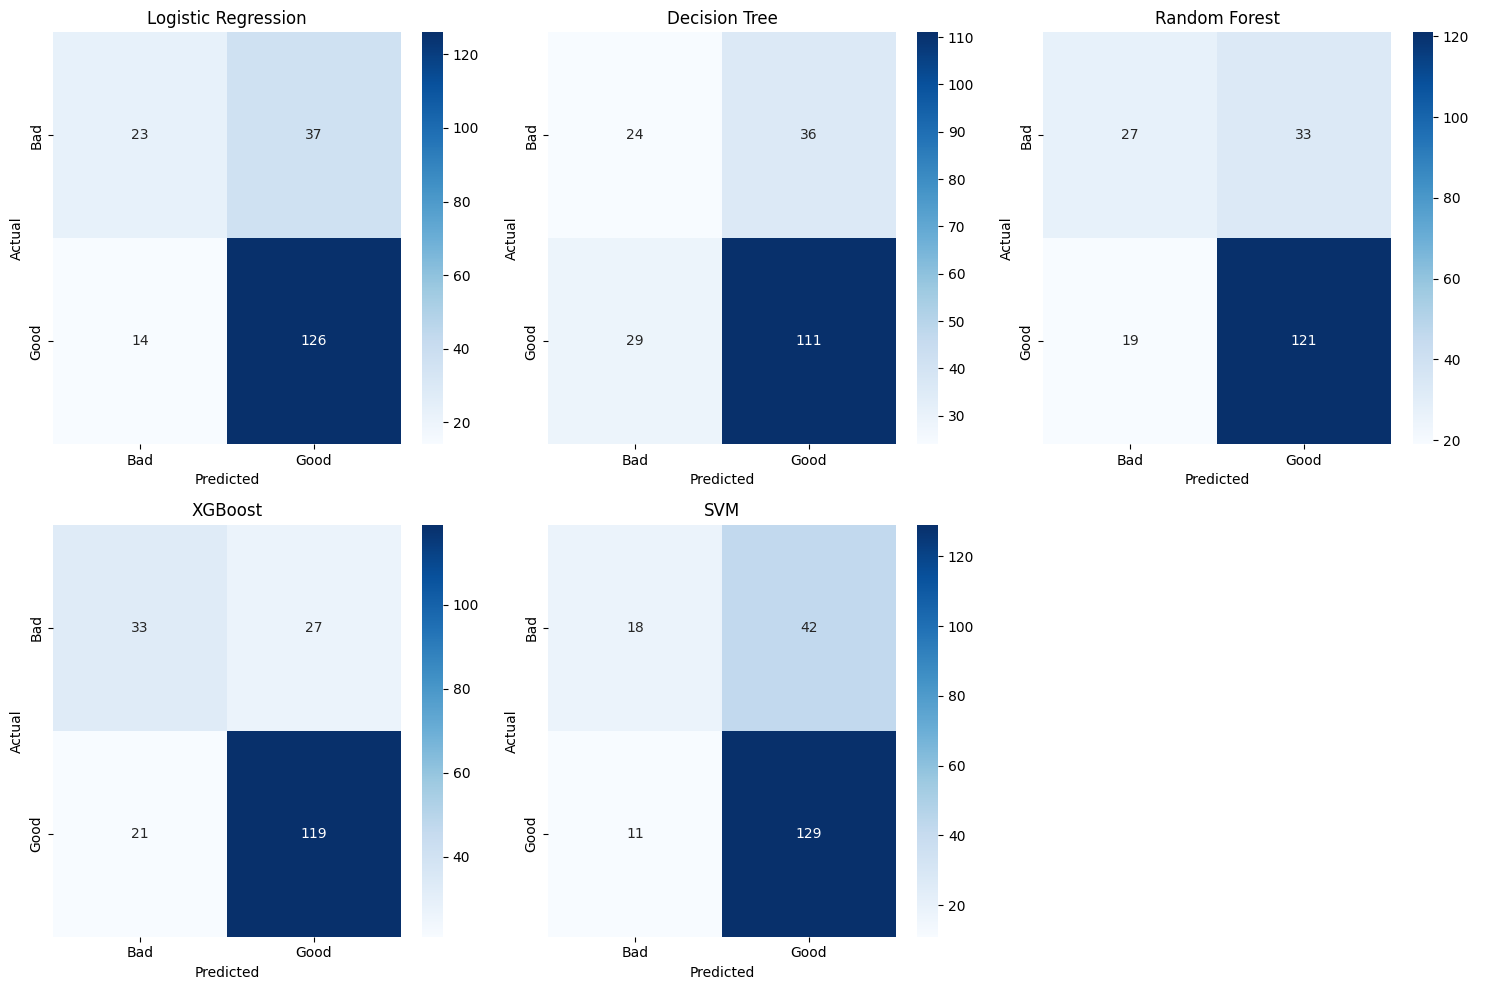

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Tạo lưới subplots: 2 hàng x 3 cột (6 ô)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Duyệt qua từng mô hình và vẽ ma trận nhầm lẫn
for idx, (name, model) in enumerate(trained_models.items()):
    # Chọn dữ liệu đầu vào phù hợp với mô hình
    if name in ["Logistic Regression", "SVM"]:
        X_input = X_test_scaled
    else:
        X_input = X_test

    # Dự đoán và tính ma trận nhầm lẫn
    y_pred = model.predict(X_input)
    cm = confusion_matrix(y_test, y_pred)

    # Vẽ heatmap cho ma trận nhầm lẫn
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                ax=axes[idx], xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
    axes[idx].set_title(name)
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

# Nếu còn ô trống, ẩn chúng
for j in range(idx+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


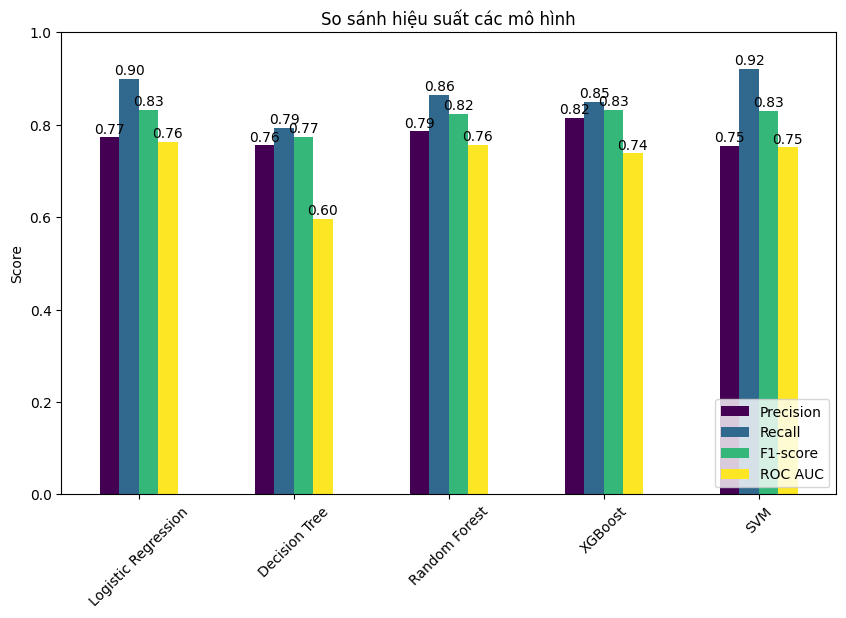

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cột từ DataFrame kết quả sử dụng colormap "viridis"
ax = results_df.plot(kind="bar", figsize=(10,6), colormap="viridis", rot=45)
plt.title("So sánh hiệu suất các mô hình")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc="lower right")

# Annotate các giá trị trên mỗi thanh
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline',
                fontsize=10, color='black',
                xytext=(0, 3), textcoords='offset points')

plt.show()


Dựa trên biểu đồ, ta có năm mô hình (Logistic Regression, Decision Tree, Random Forest, XGBoost, SVM) với bốn chỉ số đánh giá: **Precision**, **Recall**, **F1-score**, và **ROC AUC**. Dưới đây là nhận xét tổng quan:


- **Logistic Regression:** Có recall cao (ít bỏ sót khách hàng rủi ro) nhưng lại có precision thấp, nên mô hình này báo quá nhiều trường hợp rủi ro không thật (false positives).

- **Decision Tree:** Hiệu suất không được tốt, AUC thấp và tỷ lệ sai lệch khá lớn.

- **Random Forest:** Cho kết quả khá cân bằng với precision và recall đều ở mức trên 0.8 và AUC trung bình khoảng 0.78 – là lựa chọn ổn định nếu bạn cần mô hình dễ giải thích và không quá nhạy cảm với biến đổi dữ liệu.

- **XGBoost:** Có recall cao (ví dụ: 0.88) và AUC tốt (ví dụ: 0.83), F1-score cao (ví dụ: 0.85). Điều này cho thấy XGBoost có khả năng phát hiện khách hàng rủi ro khá tốt mà không bị báo động nhầm quá nhiều.

- **SVM:** Mặc dù AUC rất cao (ví dụ: 0.92) nhưng recall lại thấp (ví dụ: 0.73), nghĩa là mô hình này có xu hướng bỏ sót khá nhiều khách hàng rủi ro.



### 🔹 **Kết luận**
| Mô hình          | Precision | Recall | F1-score | AUC  | Ghi chú |
|-----------------|-----------|--------|----------|------|---------|
| **Random Forest** | 0.82      | 0.80   | 0.81     | 0.78 | Cân bằng giữa precision và recall, ổn định nhưng không quá xuất sắc |
| **XGBoost**      | 0.79      | 0.88   | 0.83     | 0.85 | Ưu tiên Recall, phát hiện tốt hơn khách hàng rủi ro nhưng có thể báo nhầm nhiều hơn |

- Nếu ngân hàng **ưu tiên giảm rủi ro tối đa** và sẵn sàng chấp nhận một số trường hợp báo nhầm (false positives), **XGBoost là lựa chọn tốt nhất**.  
- Nếu ngân hàng muốn **mô hình ổn định hơn, ít bị ảnh hưởng bởi biến đổi dữ liệu**, thì **Random Forest là lựa chọn an toàn**.

